In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from lab_processing import print_errors, create_plot

In [2]:
data1 = pd.read_csv('data/data_1.tsv', sep='\t')
data2 = pd.read_csv('data/data_2.tsv', sep='\t')

In [3]:
data = pd.concat([data1, data2], ignore_index=True)
data[['time2', 'ptcls2']] = data.groupby('plates')[['time', 'particles']].transform('sum')
data['width'] = 2 * data['plates']

<AxesSubplot:xlabel='plates'>

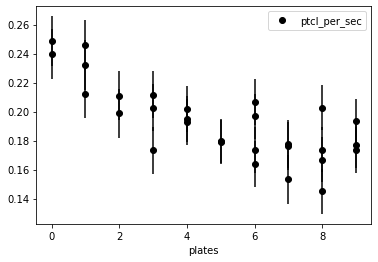

In [4]:
data['ptcl_per_sec'] = data['particles'] / data['time']
data.plot(x='plates', y='ptcl_per_sec', fmt='ok', yerr=(data['particles'] ** (-0.5) * data['ptcl_per_sec']))

In [5]:
df = data.sort_values(by=['plates']).drop_duplicates(subset=['plates'], ignore_index=True).loc[:, ['time2', 'ptcls2', 'plates']]
df.columns = ['time', 'particles', 'plates']
df['width'] = df['plates'] * 2
df['ptcl_per_sec'] = df['particles'] / df['time']

df

,time,particles,plates,width,ptcl_per_sec
0,1620,395,0,0,0.243827
1,2340,539,1,2,0.230342
2,1620,331,2,4,0.204321
3,1920,377,3,6,0.196354
4,1920,377,4,8,0.196354
5,1320,237,5,10,0.179545
6,2640,485,6,12,0.183712
7,2040,347,7,14,0.170098
8,2640,458,8,16,0.173485
9,1920,347,9,18,0.180729


<AxesSubplot:xlabel='width'>

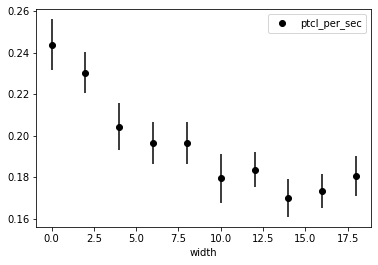

In [6]:
sigma_gnrl = (df['particles'] ** (-0.5) * df['ptcl_per_sec']).to_numpy()
df.plot(x='width', y='ptcl_per_sec', fmt='ok', yerr=sigma_gnrl)

In [7]:
x = np.linspace(df.width.min(), df.width.max(), 200)

2
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.00210768484231515		+/- 0.00053313 (25.29%)
    k0 =  0.208759402154521		+/- 0.0063529 (3.043%)



3
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.00182251878023937		+/- 0.0006803 (37.33%)
    k0 =   0.20476707728546		+/- 0.0086052 (4.202%)



4
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.00157029857397504		+/- 0.00093979 (59.85%)
    k0 =  0.201067847593583		+/- 0.012632 (6.282%)



5
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.000392992424242429		+/- 0.00099135 (252.3%)
    k0 =  0.183015819964349		+/- 0.014159 (7.737%)





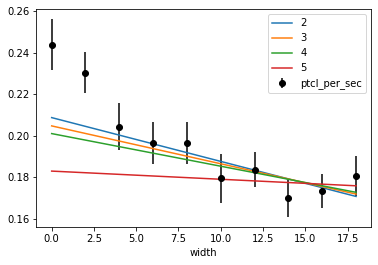

In [8]:
fig, ax = plt.subplots()
df.plot(x='width', y='ptcl_per_sec', ax=ax, fmt='ok', yerr=sigma_gnrl)
for i in range(2, 6):
    popt_i, pcov_i = np.polyfit(df['width'][i:], df['ptcl_per_sec'][i:], deg=1, cov=True)
    ax.plot(x, np.polyval(popt_i, x), label=f'{i}')
    print(i, end='')
    print_errors(popt_i, pcov_i)
    print('\n')
ax.legend()

In [9]:
def approx_func(x, A, B, C):
    return A * np.exp(-x / B) + C

In [10]:
popt_gnrl, pcov_gnrl = curve_fit(approx_func, df['width'], df['ptcl_per_sec'])
gnrl_apx_std = np.absolute(df['ptcl_per_sec'] - approx_func(df['width'], *popt_gnrl)).std()
print_errors(popt_gnrl, pcov_gnrl)


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k2 = 0.0754427249435815		+/- 0.0066155 (8.769%)
    k1 =   5.86142153249205		+/- 1.4326 (24.44%)
    k0 =  0.170640888849677		+/- 0.0059227 (3.471%)



Text(0.5, 1.0, 'Particles per second')

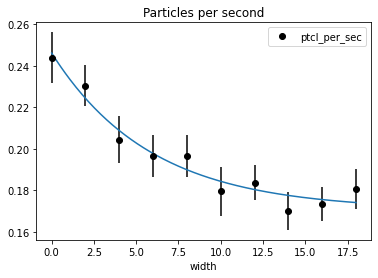

In [11]:
df.plot(x='width', y='ptcl_per_sec', fmt='ok', yerr=sigma_gnrl)
plt.plot(x, approx_func(x, *popt_gnrl))
plt.title('Particles per second')

In [12]:
n = 2
popt_line = np.polyfit(df['width'][n:], df['ptcl_per_sec'][n:], deg=1)
line_apx_std = np.absolute(df['ptcl_per_sec'][n:] - approx_func(df['width'], *popt_gnrl)).std()
df['soft'] = df['ptcl_per_sec'] - np.polyval(popt_line, df['width'])

sigma_soft = np.sqrt(line_apx_std ** 2 + sigma_gnrl ** 2)

In [13]:
popt_soft, pcov_soft = curve_fit(approx_func, df['width'], df['soft'], sigma=sigma_soft)
soft_apx_std = np.absolute(df['soft'] - approx_func(df['width'], *popt_soft)).std()
print_errors(popt_soft, pcov_soft)


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k2 = 0.0400345038712608		+/- 0.0085268 (21.3%)
    k1 =   2.99963009590395		+/- 1.3724 (45.75%)
    k0 = -0.00174534280198516		+/- 0.0033458 (191.7%)



Text(0.5, 1.0, 'Soft component')

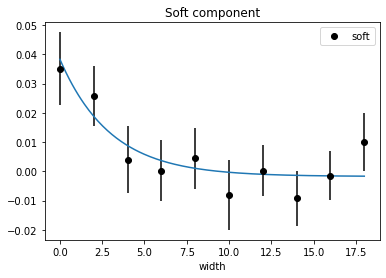

In [14]:
df.plot(x='width', y='soft', fmt='ok', yerr=sigma_soft)
plt.plot(x, approx_func(x, *popt_soft))
plt.title('Soft component')

In [15]:
df['hard'] = approx_func(df['width'], *popt_gnrl) - approx_func(df['width'], *popt_soft)
sigma_hard = np.sqrt(gnrl_apx_std ** 2 + soft_apx_std ** 2 + sigma_gnrl ** 2)

In [16]:
popt_hard, pcov_hard = curve_fit(approx_func, df['width'], df['hard'], sigma=sigma_hard)
hard_apx_std = np.absolute(df['hard'] - approx_func(df['width'], *popt_hard)).std()
print_errors(popt_hard, pcov_hard)


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k2 = 0.0515719131838969		+/- 0.0067179 (13.03%)
    k1 =   15.4771226738188		+/- 3.8266 (24.72%)
    k0 =  0.158586245579679		+/- 0.0073569 (4.639%)



Text(0.5, 1.0, 'Hard component')

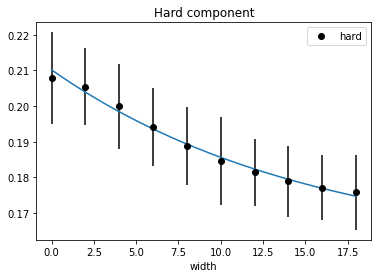

In [17]:
df.plot(x='width', y='hard', fmt='ok', yerr=sigma_hard)
plt.plot(x, approx_func(x, *popt_hard))
plt.title('Hard component')

# Итоговые графики

In [18]:
popt_gnrl

array([0.07544272, 5.86142153, 0.17064089])

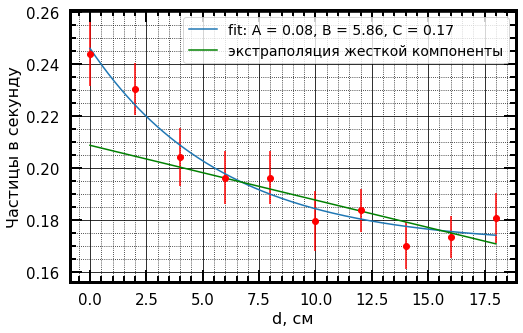

In [19]:
fig1, ax1 = create_plot(8, 5)
ax1.errorbar(df['width'], df['ptcl_per_sec'], fmt='or', yerr=sigma_gnrl)
ax1.plot(x, approx_func(x, *popt_gnrl), label='fit: A = {:.2f}, B = {:.2f}, C = {:.2f}'.format(*popt_gnrl))
ax1.plot(x, np.polyval(popt_line, x), color='green', label='экстраполяция жесткой компоненты')

ax1.set_xlabel('d, см', fontsize=16)
ax1.set_ylabel('Частицы в секунду', fontsize=16)
ax1.legend(fontsize=14)

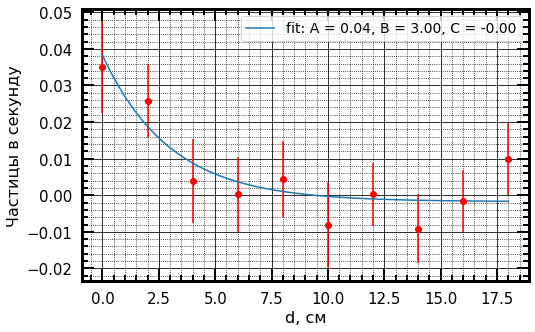

In [20]:
fig2, ax2 = create_plot(8, 5)
ax2.errorbar(df['width'], df['soft'], fmt='or', yerr=sigma_soft)
ax2.plot(x, approx_func(x, *popt_soft), label='fit: A = {:.2f}, B = {:.2f}, C = {:.2f}'.format(*popt_soft))

ax2.set_xlabel('d, см', fontsize=16)
ax2.set_ylabel('Частицы в секунду', fontsize=16)
ax2.legend(fontsize=14)

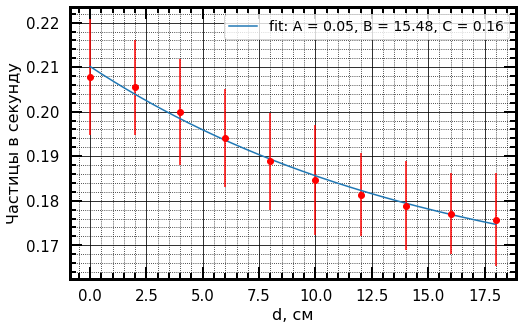

In [21]:
fig3, ax3 = create_plot(8, 5)
ax3.errorbar(df['width'], df['hard'], fmt='or', yerr=sigma_hard)
ax3.plot(x, approx_func(x, *popt_hard), label='fit: A = {:.2f}, B = {:.2f}, C = {:.2f}'.format(*popt_hard))

ax3.set_xlabel('d, см', fontsize=16)
ax3.set_ylabel('Частицы в секунду', fontsize=16)
ax3.legend(fontsize=14)

In [22]:
for i, fig in enumerate([fig1, fig2, fig3]):
    fig.tight_layout()
    fig.savefig(f'graphs/plot_{i+1}.pdf')

In [23]:
rho = 11.34
coefs = np.array([x[1] for x in [popt_gnrl, popt_soft, popt_hard]])
lmbds = coefs * rho
lmd_err = np.array([np.sqrt(np.diag(x))[1] for x in [pcov_gnrl, pcov_soft, pcov_hard]])/coefs * lmbds

In [24]:
print_errors(lmbds, np.vstack([lmd_err ** 2]*3))


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k2 =   66.4685201784599		+/- 16.245 (24.44%)
    k1 =   34.0158052875507		+/- 15.563 (45.75%)
    k0 =   175.510571121105		+/- 43.394 (24.72%)



In [25]:
S = 8.4 * 30
l = 39
omega = 4 * S / l**2
omega_eps = np.sqrt((0.05/8.4)**2 + (0.05/30)**2 + (2/l)**2)
omega, omega_eps * omega

(0.6627218934911243, 0.03423173428779711)

In [26]:
I_hard = (df['ptcl_per_sec'] - df['soft']).iloc[0] / (S * omega)
I_soft = df['soft'].iloc[0] / (S * omega)

I_hard_sigma = (sigma_hard/df['hard']).iloc[0] * I_hard
I_soft_sigma = (sigma_soft/df['soft']).iloc[0] * I_soft

In [27]:
I_hard, I_hard_sigma, I_hard_sigma/I_hard

(0.0012500120097829496, 7.781072764092813e-05, 0.06224798404492056)

In [28]:
I_soft, I_soft_sigma, I_soft_sigma/I_soft

(0.00020997913688147737, 7.46320138689368e-05, 0.3554258531458904)

In [29]:
# data1.to_latex('tables/data1.tex', index=False, label='tab:data1', caption='Данные с первой установки')
# data2.to_latex('tables/data2.tex', index=False, label='tab:data2', caption='Данные со второй установки')